# Building a fraud detection model with Amazon SageMaker

This notebook demonstrates the use of Amazon SageMakwer's implementation of the XGBoost algorithm to train and host a fraud detection model trained on a credit card payment dataset from the DefeatFraud research project. Please see the Data Ackowledgments section at the end of this notebook to learn more about the dataset.

## Set-up

In this section, we will import the necessary libraries and setup variables to work with the dataset and the SageMaker sdk in this notebook.

Let's start by specifying:

* The IAM role associated with this SageMaker notebook instance.
* The S3 bucket used to store the data used to train the model as well as trained model artifacts.

We will use the Amazon SageMaker default bucket for the selected AWS region, and then define a key prefix to make sure all objects have share the same prefix for easier discoverability.

In [68]:
import boto3
import os
import sagemaker

session = sagemaker.Session()

bucket = session.default_bucket()
sagemaker_iam_role = sagemaker.get_execution_role()

prefix = 'sagemaker/DEMO-xgboost-fraud'

Now we will download, extract and read the data set and read the credit card data set into a pandas dataframe.

In [ ]:
%%bash
wget https://s3-us-west-2.amazonaws.com/sagemaker-e2e-solutions/fraud-detection/creditcardfraud.zip
unzip creditcardfraud.zip

In [108]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import pickle

data = pd.read_csv('creditcard.csv', delimiter=',')

In [83]:
print(data.columns)
data.head()

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [73]:
data.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,3.919560e-15,5.688174e-16,-8.769071e-15,2.782312e-15,-1.552563e-15,2.010663e-15,-1.694249e-15,-1.927028e-16,-3.137024e-15,...,1.537294e-16,7.959909e-16,5.367590e-16,4.458112e-15,1.453003e-15,1.699104e-15,-3.660161e-16,-1.206049e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


The class column corresponds to whether or not a transaction is fradulent. We see that the majority of data is non-fraudulant with only $492$ ($.173\%$) of the data corresponding to fraudulant examples.

In [4]:
nonfrauds, frauds = data.groupby('Class').size()
print('Number of frauds: ', frauds)
print('Number of non-frauds: ', nonfrauds)
print('Percentage of fradulent data:', 100.*frauds/(frauds + nonfrauds))

Number of frauds:  492
Number of non-frauds:  284315
Percentage of fradulent data: 0.1727485630620034


At this point we would typically perform some additional feature engineering on our datset before training a model. Because our dataset has already been processed to some extent, we will skip this for the purposes of this example and move straight to the training. 

Data processing and feature engineering in SageMaker can be performed in the notebook instance itself, but [Processing Jobs](https://docs.aws.amazon.com/sagemaker/latest/dg/processing-job.html) are recommended for larger workloads. Processing Jobs can be used to process terabytes of data in a SageMaker-managed cluster separate from the instance running your notebook server to run your data processing workloads, such as feature engineering, data validation, model evaluation, and model interpretation. 

## Model training

In a typical SageMaker workflow, notebooks are only used for prototyping and can be run on relatively inexpensive and less powerful instances, while processing, training and model hosting tasks are run on separate, more powerful SageMaker-managed instances. We could use the xgboost or sklearn libraries to train a model in our notebook instance, but it is recommended to use **training jobs** to take advantage of more powerful compute as well as logging and monitoring. 

### Upload training, validation, and test sets to S3

The training jobs will first download our training and validation datasets from a location in S3, so let's first prepare those csv files and upload them to our S3 bucket. SageMaker's built-in XGBoost algorithm requires that the target variable is in the first column and that the CSV does not have a header record so we will move the Class column from last to first.

In [118]:
data = pd.concat([data['Class'], data.drop(['Class'], axis=1)], axis=1)
data.head()

,Class,Time,V1,V2,V3,V4,V5,V6,V7,V8,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
0,0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,...,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62
1,0,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,...,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69
2,0,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,...,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66
3,0,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,...,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50
4,0,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,...,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99


To upload the data to S3, we will leverage on the AWS Python SDK (boto3) as follows:

In [28]:
train_data, validation_data, test_data = np.split(model_data.sample(frac=1, random_state=1729), 
                                                  [int(0.7 * len(model_data)), int(0.9 * len(model_data))])
train_data.to_csv('train.csv', header=False, index=False)
validation_data.to_csv('validation.csv', header=False, index=False)


boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'train/train.csv')) \
                                .upload_file('train.csv')
boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'validation/validation.csv')) \
                                .upload_file('validation.csv')
s3_train_data = 's3://{}/{}/train/train.csv'.format(bucket, prefix)
s3_validation_data = 's3://{}/{}/validation/validation.csv'.format(bucket, prefix)
print('Uploaded training data location: {}'.format(s3_train_data))
print('Uploaded training data location: {}'.format(s3_validation_data))

output_location = 's3://{}/{}/output'.format(bucket, prefix)
print('Training artifacts will be uploaded to: {}'.format(output_location))

Uploaded training data location: s3://sagemaker-us-east-1-517094003386/sagemaker/DEMO-xgboost-fraud/train/train.csv
Uploaded training data location: s3://sagemaker-us-east-1-517094003386/sagemaker/DEMO-xgboost-fraud/validation/validation.csv
Training artifacts will be uploaded to: s3://sagemaker-us-east-1-517094003386/sagemaker/DEMO-xgboost-fraud/output


## Train a model using SageMaker's built-in XGBoost algorithm

The [XGBoost](https://github.com/dmlc/xgboost) (eXtreme Gradient Boosting) is a popular and efficient open-source implementation of the gradient boosted trees algorithm. Gradient boosting is a supervised learning algorithm that attempts to accurately predict a target variable by combining an ensemble of estimates from a set of simpler and weaker models. The XGBoot algorithm performs well in a variety of machine learning contexts because of its robust handling of a variety of data types, relationships, distributions, and the variety of hyperparameters that you can fine-tune. 

SageMaker abstracts training with **Estimators** objects which we will create using the SageMaker Python SDK.

 We can specify a few parameters like what type of training instances we'd like to use and how many, as well as our XGBoost hyperparameters.  A few key hyperparameters are:
- `max_depth` controls how deep each tree within the algorithm can be built.  Deeper trees can lead to better fit, but are more computationally expensive and can lead to overfitting.  There is typically some trade-off in model performance that needs to be explored between a large number of shallow trees and a smaller number of deeper trees.
- `subsample` controls sampling of the training data.  This technique can help reduce overfitting, but setting it too low can also starve the model of data.
- `num_round` controls the number of boosting rounds.  This is essentially the subsequent models that are trained using the residuals of previous iterations.  Again, more rounds should produce a better fit on the training data, but can be computationally expensive or lead to overfitting.
- `eta` controls how aggressive each round of boosting is.  Larger values lead to more conservative boosting.
- `gamma` controls how aggressively trees are grown.  Larger values lead to more conservative models.


In [88]:
hyperparameters = {
    "max_depth": 5,
    "eta": 0.2,
    "gamma": 4,
    "min_child_weight": 6,
    "silent": 0,
    "subsample": 0.8,
    "objective": "binary:logistic",
    "num_round": 100
}

In [98]:
from sagemaker.amazon.amazon_estimator import get_image_uri

# this line automatically looks for the XGBoost image URI in Elastic Container Regsitry (ECR)
container = get_image_uri(boto3.Session().region_name, 'xgboost')

xgb_builtin = sagemaker.estimator.Estimator(container,
                                    role=sagemaker_iam_role, 
                                    train_instance_count=1, 
                                    train_instance_type='ml.m4.xlarge',
                                    output_path=output_location,
                                    sagemaker_session=session)

xgb_builtin.set_hyperparameters(max_depth=5,
                        eta=0.2,
                        gamma=4,
                        min_child_weight=6,
                        subsample=0.8,
                        silent=0,
                        objective='binary:logistic',
                        num_round=100)

	get_image_uri(region, 'xgboost', '0.90-1').


**Managed Spot Training**: To save on cost, we run the training using managed Spot instances. SageMaker will automatically look to see if any spot instances of the desired type are available for a max time less than the max wait time, and if one is available, run your training job on that. With Managed Spot, customers can benefit from up-to 90% savings in cost.

For BYO Containers, customers are responsible for checkpointing models for the spot instances to resume training from, if a spot instance is lost during training.

Then, because we're training with the CSV file format, we'll create s3_inputs that our training function can use as a pointer to the files in S3.

In [9]:
s3_input_train = sagemaker.s3_input(s3_data='s3://{}/{}/train'.format(bucket, prefix), content_type='csv')
s3_input_validation = sagemaker.s3_input(s3_data='s3://{}/{}/validation/'.format(bucket, prefix), content_type='csv')

Now that we've created the estimator, we call the `fit` method to run the training job.  

In [100]:
xgb_builtin.fit({'train': s3_input_train, 'validation': s3_input_validation}) 

### Automatic Hyperparameter Tuning

Selecting the right hyperparameter values to train your model can be difficult, and typically is very time consuming if done manually. The right combination of hyperparameters is dependent on your data and algorithm; some algorithms have many different hyperparameters that can be tweaked; some are very sensitive to the hyperparameter values selected; and most have a non-linear relationship between model fit and hyperparameter values. SageMaker Automatic Model Tuning helps automate the hyperparameter tuning process: it runs multiple training jobs with different hyperparameter combinations to find the set with the best model performance.

We begin by specifying the hyperparameters we wish to tune, and the range of values over which to tune each one. We also must specify an objective metric to be optimized: in this use case, we'd like to minimize the validation error.

In [22]:
from sagemaker.tuner import IntegerParameter, CategoricalParameter, ContinuousParameter, HyperparameterTuner

hyperparameter_ranges = {
  'max_depth': IntegerParameter(3, 10),
  'num_round': IntegerParameter(50, 300),
  'eta': ContinuousParameter(0.001, 0.2, scaling_type="Logarithmic"),
}

objective_metric_name = 'validation:error'
objective_type = 'Minimize'

We define a `HyperparameterTuner` object and pass in the estimator we just used to train our model. In this example SageMaker will run 15 training jobs in 3 batches by running 5 jobs in parallel. 

In [138]:
from time import gmtime, strftime 

inputs = {'train': s3_input_train, 'validation': s3_input_validation}

tuner = HyperparameterTuner(xgb_builtin,
                            objective_metric_name,
                            hyperparameter_ranges,
                            max_jobs=15,
                            max_parallel_jobs=5,
                            objective_type=objective_type)

tuning_job_name = "fraud-detection-{}".format(strftime("%d-%H-%M-%S", gmtime()))
tuner.fit({'train': s3_input_train, 'validation': s3_input_validation}, job_name=tuning_job_name, wait=False)

........................................................!


After the tuning job is finished, we can use the `HyperparameterTuningJobAnalytics` object from the SageMaker Python SDK to list the top 5 tuning jobs with the best performance. Although the results vary from tuning job to tuning job, the best validation loss from the tuning job (under the FinalObjectiveValue column) likely will be substantially lower than the validation loss from the hosted training job above.

In [24]:
tuner_metrics = sagemaker.HyperparameterTuningJobAnalytics(tuning_job_name)
tuner_metrics.dataframe().sort_values(['FinalObjectiveValue'], ascending=True).head(5)

,FinalObjectiveValue,TrainingElapsedTimeSeconds,TrainingEndTime,TrainingJobName,TrainingJobStatus,TrainingStartTime,eta,max_depth,num_round
0,0.000439,162.0,2020-06-18 18:11:06+00:00,fraud-detection-18-17-54-13-015-b0a11ad9,Completed,2020-06-18 18:08:24+00:00,0.082593,7.0,299.0
1,0.000456,122.0,2020-06-18 18:09:17+00:00,fraud-detection-18-17-54-13-014-e9397744,Completed,2020-06-18 18:07:15+00:00,0.093892,3.0,248.0
4,0.000456,118.0,2020-06-18 18:07:42+00:00,fraud-detection-18-17-54-13-011-25b1a036,Completed,2020-06-18 18:05:44+00:00,0.180291,4.0,267.0
5,0.000456,183.0,2020-06-18 18:05:39+00:00,fraud-detection-18-17-54-13-010-95273deb,Completed,2020-06-18 18:02:36+00:00,0.131110,4.0,254.0
6,0.000456,122.0,2020-06-18 18:04:31+00:00,fraud-detection-18-17-54-13-009-d80ed742,Completed,2020-06-18 18:02:29+00:00,0.176312,3.0,282.0


Retrieving the model from S3 is very easy: the hosted training estimator you created above stores a reference to the model's location in S3. You simply copy the model from S3 using the estimator's model_data property and unzip it to inspect the contents.

##  Train a model using the open source XGBoost algorithm

With Amazon SageMaker, you can use XGBoost as a built-in algorithm or framework. By using XGBoost as a framework, you have more flexibility and access to more advanced scenarios, such as k-fold cross-validation, because you can customize your own training scripts. The Amazon SageMaker Python SDK provides the XGBoost API as a framework in the same way it provides other framework APIs, such as TensorFlow, MXNet, and PyTorch.

Let's see how to train a similiar model using the XGBoost framework instead of the built-in algorithm. First we'll take a look at our training script.

In [91]:
!pygmentize ./model_scripts/train_xgboost.py

import argparse
import json
import os
import random
import pandas as pd
import glob
import pickle as pkl

import xgboost

def parse_args():

    parser = argparse.ArgumentParser()

    parser.add_argument("--max_depth", type=int, default=5)
    parser.add_argument("--eta", type=float, default=0.05)  # 0.2
    parser.add_argument("--gamma", type=int, default=4)
    parser.add_argument("--min_child_weight", type=int, default=6)
    parser.add_argument("--silent", type=int, default=0)
    parser.add_argument("--objective", type=str, default="multi:softmax")
    parser.add_argument("--num_class", type=int, default=15)
    parser.add_argument("--num_round", type=int, default=10)
    
    parser.add_argument('--train', type=str, default=os.environ.get('SM_CHANNEL_TRAIN'))
    parser.add_argument('--validation', type=str, default=os.environ.get('SM_CHANNEL_VALIDATION'))

    args = parser.parse_args()

    return args

def model_fn(model_dir):
    model_file = model_dir + '/model.bin'
    mod

The script parses arguments that are passed when the XGBoost Docker container code invokes the script for execution. These arguments represent the hyperparameters that you specify when strarting the training job plus the location of training and validation data.

We will create the `XGBoost` estimator object need to add two arguments compared to our original estimator: `entry_point` for the model training script and `source_dir` for the directory containing any files the model needs to train. Otherwise the set-up is exactly the same:

In [136]:
entry_point='train_xgboost.py'
source_dir='model_scripts/'

xgb = XGBoost(
            entry_point=entry_point,
            source_dir=source_dir,
            framework_version="0.90-2",
            role=sagemaker_iam_role, 
            train_instance_count=1, 
            train_instance_type='ml.m4.xlarge',
            output_path=output_location,
            sagemaker_session=session,
            train_use_spot_instances=True,
            train_max_wait=3600,
            train_max_run=3600
            )

xgb.fit({'train': s3_input_train, 'validation': s3_input_validation}) 


### Host XGBoost Model and Serve Predictions

Let's deploy the model we just trained to a managed HTTP hosted endpoint and serve predictions.

In [ ]:
xgb.name = 'deployed-xgboost-fraud-prediction'
xgb_predictor = xgb.deploy(initial_instance_count = 1, 
                           instance_type = 'ml.m4.xlarge',
                          endpoint_name='deployed-xgboost-fraud-prediction')

-----------

### Evaluate

Now that we have a hosted endpoint running, we can make real-time predictions from our model very easily, 
simply by making an http POST request.  But first, we'll need to setup serializers and deserializers for passing our `test_data` NumPy arrays to the model behind the endpoint.

In [126]:
from sagemaker.predictor import csv_serializer 

xgb_predictor.content_type = 'text/csv'
xgb_predictor.serializer = csv_serializer
xgb_predictor.deserializer = None

Now, we'll use a simple function to:
1. Loop over our test dataset
1. Split it into mini-batches of rows 
1. Convert those mini-batchs to CSV string payloads
1. Retrieve mini-batch predictions by invoking the XGBoost endpoint
1. Collect predictions and convert from the CSV output our model provides into a NumPy array

In [127]:
def predict(data, rows=500):
    split_array = np.array_split(data, int(data.shape[0] / float(rows) + 1))
    predictions = ''
    for array in split_array:
        predictions = ','.join([predictions, xgb_predictor.predict(array).decode('utf-8')])

    return np.fromstring(predictions[1:], sep=',')

predictions = predict(test_data.as_matrix()[:, 1:])

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:9: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


There are many ways to compare the performance of a machine learning model, but let's start by simply by comparing actual to predicted values. In this case, we're simply predicting whether the customer churned (1) or not (0), which produces a simple confusion matrix.

In [128]:
test_nonfrauds, test_frauds = test_data.groupby('Class').size()
print('Number of frauds: ', test_frauds)
print('Number of non-frauds: ', test_nonfrauds)
print('Percentage of fradulent data:', 100.*test_frauds/(test_frauds + test_nonfrauds))

Number of frauds:  54
Number of non-frauds:  28427
Percentage of fradulent data: 0.1896000842667041


In [129]:
pd.crosstab(index=test_data.iloc[:, 0], columns=np.round(predictions), rownames=['actual'], colnames=['predictions'])

predictions,0.0,1.0
actual,,
0,28424,3
1,12,42


In [130]:
#precision: tp / (tp + fp)
#recall: tp / (tp + fn)
from sklearn.metrics import precision_recall_fscore_support
results = precision_recall_fscore_support(test_data.iloc[:, 0],
                                         np.round(predictions))
print('precision: ', round(results[0][1], 2))
print('recall: ', round(results[1][1], 2))

precision:  0.93
recall:  0.78


Note, due to randomized elements of the algorithm, you results may differ slightly.

Of the 54 fraudsters, we've correctly predicted 40 of them (true positives). And, we incorrectly predicted 1 case of fraud (false positive). There are also 14 cases of fraud that the model classified as benign transaction (false negatives) - which can get really expensive.

An important point here is that because of the np.round() function above we are using a simple threshold (or cutoff) of 0.5. Our predictions from xgboost come out as continuous values between 0 and 1 and we force them into the binary classes that we began with. So, we should consider adjusting this cutoff. That will almost certainly increase the number of false positives, but it can also be expected to increase the number of true positives and reduce the number of false negatives.

To get a rough intuition here, let's look at the continuous values of our predictions.

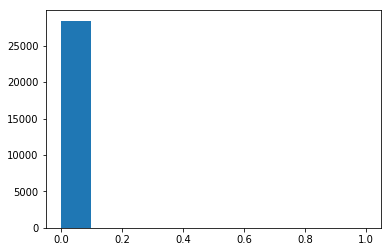

In [131]:
plt.hist(predictions)
plt.show()

By varying the cutoff threshold, we can trade false positives for false negatives. 

In [132]:
pd.crosstab(index=test_data.iloc[:, 0], columns=np.where(predictions > 0.04, 1, 0))

col_0,0,1
Class,,
0,28414,13
1,8,46


In [133]:
results = precision_recall_fscore_support(test_data.iloc[:, 0],
                                         np.where(predictions > 0.04, 1, 0))
print('precision: ', round(results[0][1], 2))
print('recall: ', round(results[1][1], 2))

precision:  0.78
recall:  0.85


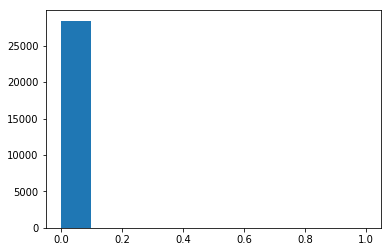

In [134]:
plt.hist(predictions)
plt.show()

### Relative cost of errors

Any practical binary classification problem is likely to produce a similarly sensitive cutoff. 
If we put an ML model into production, there are costs associated with the model erroneously assigning false positives and false negatives. Because the choice of the cutoff affects all four of these statistics, we need to consider the relative costs to the business for each of these four outcomes for each prediction.

#### Assigning costs

What are the costs for our problem fraud detection? The costs, of course, depend on the specific actions that the business takes. Let's make some assumptions here.

First, assign the cost of \$0.00 to both the true negatives (correctly recognized benign transactions) and true positives (correctly recognized fraudulent transactions). Our model essentially correctly identified both situations. One can assign a benefit (i.e. negative cost) to correctly detected fraud, but we are not going to do this here.

False negatives are the most problematic, because they represent a fraudulent transactions that slipped through our model. Based on some Internet research (see sources below), we assign a cost of \$450.00 for each one. This is the cost of false negatives.

Finally, False positives are the genuine transactions that our model would block as fraud. This would result in an annoyed customer that might possibly close the credit card account and move to another bank. We assume that it costs a \$500.00 sign-on bonus to obtain a cr. card customer and that \5 percent of annoyed customers would defect. 

Source:

https://www.creditcards.com/credit-card-news/credit-card-security-id-theft-fraud-statistics-1276.php
https://wallethub.com/edu/cc/credit-debit-card-fraud-statistics/25725/


#### Finding the optimal cutoff

It’s clear that false negatives are substantially more costly than false positives. We should be minimizing a cost function that looks like this:

```txt
$450 * FN(C) + $0 * TN(C) + 0.05*$500 * FP(C) + $0 * TP(C)
```

FN(C) means that the false negative percentage is a function of the cutoff, C, and similar for TN, FP, and TP.  We need to find the cutoff, C, where the result of the expression is smallest.

A straightforward way to do this, is to simply run a simulation over a large number of possible cutoffs.  We test 100 possible values in the for loop below.

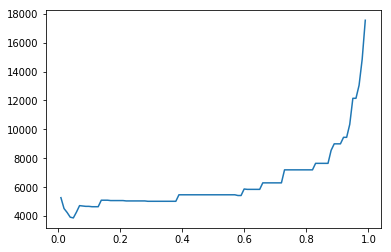

Cost is minimized near a cutoff of: 0.05


In [135]:
TN_cost = 0
TP_cost = 0
FP_cost = 0.05*500 #$cost of losing an annoyed customer (assuming 5% defection and $500 sign-on bonus)
FN_cost = 450 # $cost of of letting a fradulent transaction slip through

cutoffs = np.arange(0.01, 1, 0.01)
costs = []
for c in cutoffs:
    costs.append(np.sum(np.sum(np.array([[TN_cost, FP_cost], [FN_cost, TP_cost]]) * 
                               pd.crosstab(index=test_data.iloc[:, 0], 
                                           columns=np.where(predictions > c, 1, 0)))))

costs = np.array(costs)
plt.plot(cutoffs, costs)
plt.show()
print('Cost is minimized near a cutoff of:', cutoffs[np.argmin(costs)])

## Clean up

We will leave the prediction endpoint running at the end of this notebook so we can handle incoming event streams. However, don't forget to delete the prediction endpoint when you're done. You can do that at the Amazon SageMaker console in the Endpoints page. Or you can run `xgb_predictor.delete_endpoint()`

In [49]:
xgb_predictor.delete_endpoint()


## Data Acknowledgements

The dataset used to demonstrated the fraud detection solution has been collected and analysed during a research collaboration of Worldline and the Machine Learning Group (http://mlg.ulb.ac.be) of ULB (Université Libre de Bruxelles) on big data mining and fraud detection. More details on current and past projects on related topics are available on https://www.researchgate.net/project/Fraud-detection-5 and the page of the [DefeatFraud](https://mlg.ulb.ac.be/wordpress/portfolio_page/defeatfraud-assessment-and-validation-of-deep-feature-engineering-and-learning-solutions-for-fraud-detection/) project
We cite the following works:
* Andrea Dal Pozzolo, Olivier Caelen, Reid A. Johnson and Gianluca Bontempi. Calibrating Probability with Undersampling for Unbalanced Classification. In Symposium on Computational Intelligence and Data Mining (CIDM), IEEE, 2015
* Dal Pozzolo, Andrea; Caelen, Olivier; Le Borgne, Yann-Ael; Waterschoot, Serge; Bontempi, Gianluca. Learned lessons in credit card fraud detection from a practitioner perspective, Expert systems with applications,41,10,4915-4928,2014, Pergamon
* Dal Pozzolo, Andrea; Boracchi, Giacomo; Caelen, Olivier; Alippi, Cesare; Bontempi, Gianluca. Credit card fraud detection: a realistic modeling and a novel learning strategy, IEEE transactions on neural networks and learning systems,29,8,3784-3797,2018,IEEE
* Dal Pozzolo, Andrea Adaptive Machine learning for credit card fraud detection ULB MLG PhD thesis (supervised by G. Bontempi)
* Carcillo, Fabrizio; Dal Pozzolo, Andrea; Le Borgne, Yann-Aël; Caelen, Olivier; Mazzer, Yannis; Bontempi, Gianluca. Scarff: a scalable framework for streaming credit card fraud detection with Spark, Information fusion,41, 182-194,2018,Elsevier
* Carcillo, Fabrizio; Le Borgne, Yann-Aël; Caelen, Olivier; Bontempi, Gianluca. Streaming active learning strategies for real-life credit card fraud detection: assessment and visualization, International Journal of Data Science and Analytics, 5,4,285-300,2018,Springer International Publishing